In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1075 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 10*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.14s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


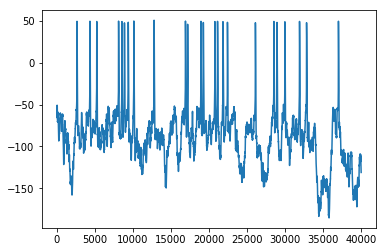

In [7]:
voltage1 = mon.v[0]/mV
plot(voltage1);

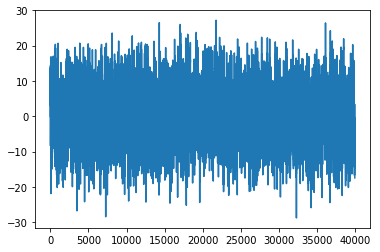

In [8]:
inp_cur1 = mon.I[0]/nA
plot(inp_cur1);

In [9]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([ 26.36,  43.36,  52.31,  81.  ,  85.38,  88.68,  93.7 , 101.06,
        127.65, 168.87, 171.72, 189.22, 192.37, 207.54, 211.04, 218.17,
        224.08, 260.81, 285.09, 289.21, 299.54, 318.77, 328.05, 369.94])]

In [10]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    neurongroup_1's variable 'm' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'n' has NaN, very large values, or encountered an error in nume

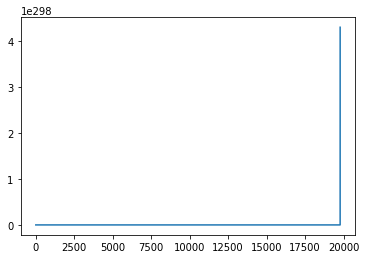

In [11]:
voltage2 = mon.v[0]/mV
plot(voltage2);

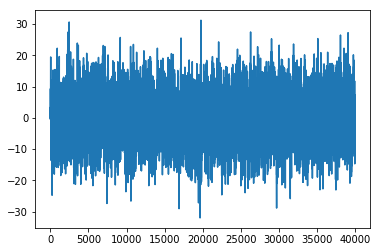

In [12]:
inp_cur2 = mon.I[0]/nA
plot(inp_cur2);

In [13]:
out_spikes2 = [spike_mon.spike_trains()[0]/ms]
out_spikes2

[array([  1.82,  30.4 ,  38.31,  50.42,  69.73,  84.92,  91.36,  96.86,
        111.26, 130.89, 160.72, 197.7 ])]

In [14]:
out_spikes1

[array([ 26.36,  43.36,  52.31,  81.  ,  85.38,  88.68,  93.7 , 101.06,
        127.65, 168.87, 171.72, 189.22, 192.37, 207.54, 211.04, 218.17,
        224.08, 260.81, 285.09, 289.21, 299.54, 318.77, 328.05, 369.94])]

In [15]:
out_spikes = [out_spikes1[0], out_spikes2[0]]
out_spikes

[array([ 26.36,  43.36,  52.31,  81.  ,  85.38,  88.68,  93.7 , 101.06,
        127.65, 168.87, 171.72, 189.22, 192.37, 207.54, 211.04, 218.17,
        224.08, 260.81, 285.09, 289.21, 299.54, 318.77, 328.05, 369.94]),
 array([  1.82,  30.4 ,  38.31,  50.42,  69.73,  84.92,  91.36,  96.86,
        111.26, 130.89, 160.72, 197.7 ])]

In [16]:
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([  0.        ,   5.03466703,   3.12431517, ..., -12.38713779,
        -14.28224272, -17.45501846]),
 array([  0.        ,   3.43020797,   4.52123455, ..., -14.72836975,
        -11.65544778,  -8.07915995])]

## Model Fitting

In [17]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau :volt
        dvt/dt = (a*v - vt) / taut :volt
        alpha : volt (constant)
        a : 1 (constant)
        R : ohm (constant)
        tau : second (constant)
        taut : second (constant)
        '''
reset = '''
v = 0*mV
vt = vt + alpha
'''

In [18]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=10*ms)

In [19]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=1000,
                     threshold='v > vt',
                     reset=reset,
                     refractory=1.4*ms,
                     param_init={'v': -65*mV},
                     )

In [20]:
result_dict, error = fitter.fit(n_rounds=40,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[5,10]*mV,
                                a = [0.1, 1],
                                R = [1, 100]*Mohm, 
                                tau = [10, 13]*ms,
                                taut = [90, 100]*ms,
                               )

WARNING    "tau" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Round 0: fit (83933983.38641551, 0.5642930288750057, 0.011177853500522646, 0.09492207161136636, 0.006026254842722045) with error: 1.6818579234972677
Round 1: fit (90345483.26255842, 0.8716465114619525, 0.012190590070454579, 0.09215989626209305, 0.006613132935170138) with error: 1.577482214661305
Round 2: fit (90345483.26255842, 0.8716465114619525, 0.012190590070454579, 0.09215989626209305, 0.006613132935170138) with error: 1.577482214661305
Round 3: fit (92461129.35306963, 0.7692745877980636, 0.010469672772990726, 0.09165671317697492, 0.005413143657676987) with error: 1.5486208508648902
Round 4: fit (94265198.6506527, 0.7090851852334517, 0.010573093051768534, 0.09090970202227587, 0.005478060186799578) with error: 1.5367149758454106
Round 5: fit (94265198.6506527, 0.7090851852334517, 0.010573093051768534, 0.09090970202227587, 0.005478060186799578) with error: 1.5367149758454106
Round 6: fit (95033685.84432347, 0.8992457717928604, 0.011157757094408752, 0.09156305570525272, 0.005243549650

KeyboardInterrupt: 

In [ ]:
result_dict

In [ ]:
error

In [ ]:
1 - error

In [ ]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

In [ ]:
print(len(out_spikes[0]))
print(len(spikes[0]))

In [ ]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [ ]:
fits = fitter.generate(params=None, output_var='v',)

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))

ax[0].plot(voltage1);
ax[0].plot(fits[0]/mV)

ax[1].plot(voltage2);
ax[1].plot(fits[1]/mV);
